# Defining Params

In [2]:
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)
set_session(sess)

Using TensorFlow backend.


In [3]:
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import json
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
import seaborn as sns
import pandas as pd
from keras.models import model_from_json
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

In [4]:
batch_size = 32
img_height=80
img_width = 256
approx_fold_size = 1000

# Load Model

In [5]:
path = "/media/romulo/6237-3231/augmented_model_v2/"
model_definition_location = path+"/augmented_model_three_classes_unfrozen_layers_weighted_v2.json"
model_weights_location = path+"/augmented_model_three_classes_unfrozen_layers_weighted_v2.h5"
model_labels_location = path+"/augmented_model_three_classes_unfrozen_layers_weighted_v2_class_indices.json"
test_folder = "/media/romulo/6237-3231/soundflux_augmented/spectrograms/split/test"

In [6]:
with open(model_definition_location, 'r') as json_file:
    loaded_model_json = json_file.read()
model = model_from_json(loaded_model_json)
# load weights into new model
model.load_weights(model_weights_location)
with open(model_labels_location, 'r') as json_file:
    label_map = json.load(json_file)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


# Evaluate Model

In [7]:
datagen = ImageDataGenerator(rescale=1./255,
                            #rotation_range=10,
                            width_shift_range=0.1,
                            #horizontal_flip=True,
                            #vertical_flip=True,
                            fill_mode='nearest')

In [8]:
test_generator = datagen.flow_from_directory(test_folder,
                                          target_size = (img_height,img_width),
                                          class_mode = 'categorical',
                                          batch_size = batch_size,
                                          shuffle=False, 
                                          seed=7)

Found 4976 images belonging to 3 classes.


In [9]:
steps = np.ceil(len(test_generator.classes)/batch_size)

In [10]:
predictions = model.predict_generator(test_generator,
                                      steps = steps,
                              verbose=True)

156/156 [==============================] - 551s 4s/step


# Confusion Matrix

In [11]:
y_pred = np.argmax(predictions, axis=1)

In [12]:
print('Confusion Matrix')
cm = confusion_matrix(test_generator.classes, y_pred)
print(cm)

Confusion Matrix
[[ 713    0    0]
 [ 337  996    0]
 [   0    0 2930]]


In [13]:
normalized = cm/cm.sum(axis=1)[:, np.newaxis]

In [14]:
sns.set(font_scale=1.8)

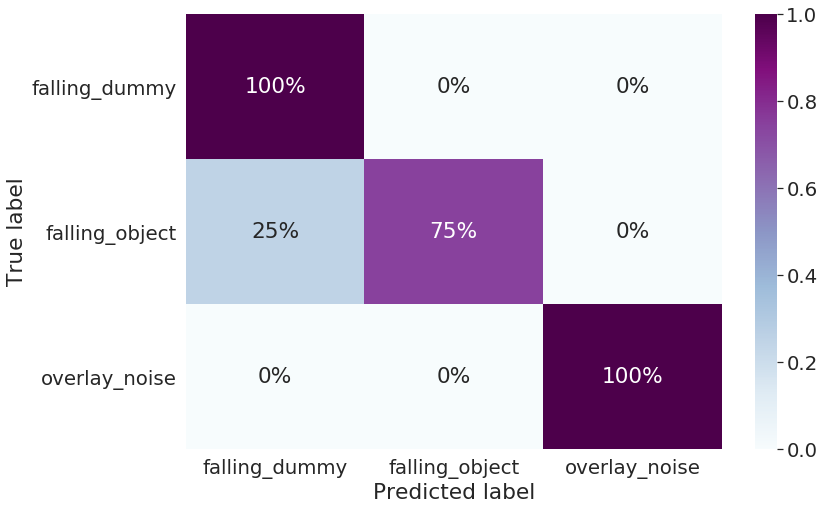

In [15]:
cm_df = pd.DataFrame(normalized,
                     index = test_generator.class_indices.keys(), 
                     columns = test_generator.class_indices.keys())

plt.figure(figsize=(12,8))
sns.heatmap(cm_df, annot=True, fmt='.0%', cmap="BuPu")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [16]:
print('Classification Report')
print(classification_report(test_generator.classes, y_pred, 
                            target_names = test_generator.class_indices.keys()))

Classification Report
                precision    recall  f1-score   support

 falling_dummy       0.68      1.00      0.81       713
falling_object       1.00      0.75      0.86      1333
 overlay_noise       1.00      1.00      1.00      2930

     micro avg       0.93      0.93      0.93      4976
     macro avg       0.89      0.92      0.89      4976
  weighted avg       0.95      0.93      0.93      4976

